# Imports

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from dotenv import load_dotenv, find_dotenv
from openai import OpenAI

import utility.utility as util
import utility.prompts as prompts

import json

# Progress Bars:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

# Below import and instructions simply for display
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# resets import once changes have been applied
%load_ext autoreload
%autoreload 2

# Directory and File Paths

In [2]:
path_data = os.path.join(os.getcwd(), "data")

path_stmts = os.path.join(path_data, "predict")

file_excel = os.path.join(path_data, "examples_altered.xlsx")

# Load Environment Variables

In [3]:
_ = load_dotenv(find_dotenv())

# Load Data

In [4]:
df_meta = pd.read_excel(file_excel, sheet_name="Sheet1")

# Preliminary Adjustments

In [5]:
df_meta.dropna(axis=1, inplace=True, thresh = int(df_meta.shape[0]*.1))
df_meta.drop(columns=["checked by", "new", "manual", "page (txt)", "manual", "note"], inplace=True)
df_meta["filename"] = df_meta["filename"].astype("str") + ".txt"
df_meta["filepath"] = df_meta["filename"].apply(lambda x: os.path.join(path_stmts, x))

# Split "Train" "Test"

In [6]:
prompt_indeces = [0,1,2,3,4,5,6,7,16,17,20,21,26,27,34,35,36,37]
test_indeces = [i for i in df_meta.index if i not in prompt_indeces]

In [7]:
prompt_df = df_meta.iloc[prompt_indeces,:].copy()
test_df = df_meta.iloc[test_indeces,:].copy()
del df_meta

# Extract most common terms:

In [8]:
min_ratio = .5

terms_auditor = util.concat_terms(util.det_commonly_used_terms(prompt_df["terms_audit"], min_ratio=min_ratio), ", ")
terms_notes = util.concat_terms(util.det_commonly_used_terms(prompt_df["terms_notes"], min_ratio=min_ratio), ", ")
#terms_acc_stds = util.concat_terms(util.det_commonly_used_terms(df_meta["term"], min_ratio=0), " - ")

section_terms_auditor = prompts.common_terms_section_auditor.format(terms_auditor = terms_auditor)
section_terms_notes = prompts.common_terms_section_notes.format(terms_notes = terms_notes)
#section_terms_acc_stds = prompts.common_terms_accounting_stds.format(acc_std = terms_acc_stds)

# Construct Base Prompt

## System Context

In [9]:
system = prompts.system_context_basic + \
         prompts.task_descr_1 + \
         section_terms_auditor + \
         section_terms_notes + \
         prompts.instruction_1 + \
         prompts.answer_format1

### User_Assitant Context - examples in conversations user-assistant

In [10]:
user_assistant = util.get_user_assistant_context_format1(prompt_df, "filename", "source", "paragraph (context)", "sentence", "term")

# Examples in one prompt

In [11]:
prompt_examples = util.get_examples_prompt(prompts.examples_base1, prompt_df, "filename", "source", "paragraph (context)", "sentence", "term")
system += prompt_examples

# Extract Text Prompt

In [12]:
df_inputs = test_df[['filepath', 'filename','cc_iso3']].copy().drop_duplicates()
df_inputs['prompt'] = df_inputs['filepath'].apply(util.parse_txt).apply(util.clean_text)

In [13]:
df_inputs['num_tokens'] = df_inputs['prompt'].apply(util.count_tokens)
base_prompt_length = util.count_tokens(system)
df_inputs['com_num_tokens'] = df_inputs['num_tokens'] + base_prompt_length

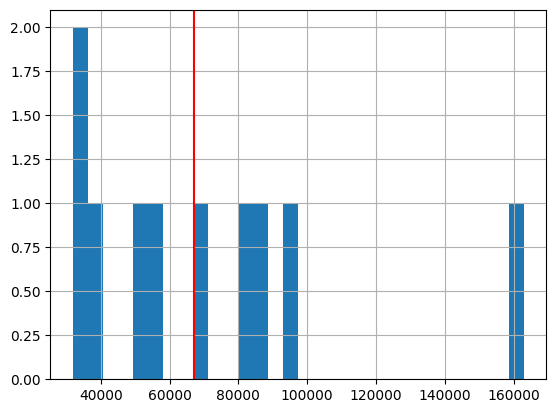

In [14]:
df_inputs['num_tokens'].hist(bins=30)
plt.axvline(x=df_inputs['com_num_tokens'].median(), color = "r")

# Segment Stmts

In [15]:
util.segment_text_column(df_inputs, "filename", "prompt", 12000, 200)

,filepath,filename,cc_iso3,prompt,num_tokens,com_num_tokens,segment
0,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,CEI Contract Manufacturing Limited Company Reg...,12000,36936,0
1,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,is not be remeasured until it is finally sett...,12000,36936,1
2,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,in force (unless such compliance has been wai...,8309,36936,2
3,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,"Transcending Boundaries, Growing Opportunities...",12000,43476,0
4,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,individual performance while the remuneration...,12000,43476,1
...,...,...,...,...,...,...,...
58,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60783048.txt,FRA,Group Terms and conditions: The taxable incom...,12000,87785,5
59,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,60783048.txt,FRA,approves the consolidated financial statement...,11958,87785,6
60,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNU...,12000,38886,0
61,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,"and Mr Nicholson, who were appointed to the B...",12000,38886,1


In [16]:
df_inputs.loc[22]

filepath          C:\Users\ilias\Desktop\UniMaResearch2023\Extra...
filename                                              172416837.txt
cc_iso3                                                         CAN
prompt            RITCHIE BROS AUCTIONEERS INC Form -K Filed on ...
num_tokens                                                   163019
com_num_tokens                                               168046
Name: 22, dtype: object

# reduce to below 60k tokens

In [17]:
df_inputs['com_num_tokens']

8      36936
10     43476
12     74628
14     58243
18     59680
22    168046
24     99259
28     92588
30     87785
32     38886
Name: com_num_tokens, dtype: int64

In [18]:
df_inputs = df_inputs[df_inputs.num_tokens <= 60000]

In [19]:
df_inputs['com_num_tokens'].cumsum()

8      36936
10     80412
14    138655
18    198335
32    237221
Name: com_num_tokens, dtype: int64

# Calculate Cost

In [20]:
util.calc_price_gpt(df_inputs.shape[0], df_inputs.com_num_tokens.mean(), 1, .01, 1000)

{'$ (excl. VAT)': 2.37221}

In [21]:
util.calc_price_gpt(100_000, 16_000, 2, .0005, 1_000)

{'$ (excl. VAT)': 1600.0}

In [22]:
util.calc_compute_time(100_000, 16000, 2, 160_000)

{'days': 13.0, 'hours': 21.0, 'min': 20.0, 'raw min': 20000.0}

# Prompt GPT

## Initialize Client

In [23]:
client = OpenAI()

In [36]:
print(system)


You are a financial accountant.

You are tasked to extract information contained within two sections, the auditor section and the notes section,  of a provided financial statement. More specifically, from the notes section you are tasked to extract according to what accounting standard the financial statement has been prepared, and from the auditor section you are tasked to extract what accounting standard the financial statement is in compliance with. It is possible that a financial statement is in compliance with or has been constructed according to multiple standards, in which case you should extract both - note, double standards are most likely in close vicinity to each other. I will provide you with long textual sequences. Make absolutely sure that you only respond with phrases you find within the provided financial statement. Before providing an answer, check whether you can find it within the provided text.


For the auditor part you will most likely find some of these terms, d

## Call API

In [30]:
df_inputs['output'] = df_inputs.progress_apply(lambda x: util.prompt_gpt(client, system, x.prompt, None, "gpt-4-0125-preview"), axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

2024-03-06 11:42:11.576465
2024-03-06 11:42:25.889104
2024-03-06 11:42:40.225862
2024-03-06 11:43:21.831912
2024-03-06 11:43:56.676223


# Evaluation

In [37]:
df_inputs

,filepath,filename,cc_iso3,prompt,num_tokens,com_num_tokens,output
8,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61466756.txt,SGP,CEI Contract Manufacturing Limited Company Reg...,31909,36936,ChatCompletion(id='chatcmpl-8zj0tODVqZ86N29sO7...
10,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61511488.txt,SGP,"Transcending Boundaries, Growing Opportunities...",38449,43476,ChatCompletion(id='chatcmpl-8zj18MtGl3YCVTKmy2...
14,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,62609130.txt,TUR,"CONTENTS TURCAS IN BRIEF Vision, Mission, Stra...",53216,58243,ChatCompletion(id='chatcmpl-8zj1M6JmhTzeaZaUl5...
18,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,64866413.txt,IND,SUMMIT SECURITIES LIMITED Corporate Identifica...,54653,59680,ChatCompletion(id='chatcmpl-8zj220hThbGVORDOC3...
32,C:\Users\ilias\Desktop\UniMaResearch2023\Extra...,61015098.txt,GBR,ANNUAL REPORT & ACCOUNTS AVESCO GROUP PLC ANNU...,33859,38886,ChatCompletion(id='chatcmpl-8zj2aYY876dgnaIfcG...


In [38]:
files = df_inputs.filename.values
labels = test_df[test_df.filename.isin(files)].copy()
labels[['found_sentence', 'found_term']] = ""

In [39]:
for row in df_inputs.index:
    d = json.loads(df_inputs.loc[row]["output"].choices[0].message.content)
    id = df_inputs.loc[row].filename
    
    for k, v in d.items():
        mask = (labels['filename'] == id) & (labels['source'] == k)
        labels.loc[mask, 'found_sentence'] = v['sentence'] 
        labels.loc[mask, 'found_term'] = v['term']

In [40]:
labels['cc_iso3 filename sentence term source found_sentence found_term'.split()]

,cc_iso3,filename,sentence,term,source,found_sentence,found_term
8,SGP,61466756.txt,"In our opinion, the the consolidated financial...",Singapore Financial Reporting Standards,audit,"In our opinion, the consolidated financial sta...",Singapore Financial Reporting Standards
9,SGP,61466756.txt,The consolidated financial statements of the ...,Singapore Financial Reporting Standards (“FRS”),notes,The consolidated financial statements of the G...,"Singapore Financial Reporting Standards (""FRS"")"
10,SGP,61511488.txt,"In our opinion, the financial statements of t...",Singapore Financial Reporting Standards,audit,"In our opinion, the financial statements of th...",Singapore Financial Reporting Standards
11,SGP,61511488.txt,The consolidated financial statements of the G...,"Singapore Financial Reporting Standards (""FRS"")",notes,The financial statements have been prepared in...,Singapore Financial Reporting Standards (FRS)
14,TUR,62609130.txt,the consolidated financial statements present ...,Turkish Accounting Standards.,audit,"In our opinion, the consolidated financial sta...",Turkish Accounting Standards
15,TUR,62609130.txt,The accompanying consolidated financial statem...,Turkish Accounting Standards,notes,The consolidated financial statements and disc...,the communiqué numbered II-14.1 “Communiqué on...
18,IND,64866413.txt,These consolidated financial statements have b...,Generally Accepted Accounting \nPrinciples in ...,notes,The consolidated financial statements have bee...,the communiqué numbered II-14.1 “Communiqué on...
19,IND,64866413.txt,the aforesaid \nstandalone financial statement...,accounting principles generally \naccepted in ...,audit,the group management is responsible for the pr...,turkish accounting standards
32,GBR,61015098.txt,These financial statements have been prepared ...,United Kingdom accounting standards,notes,The financial statements have been prepared un...,applicable United Kingdom accounting standards
33,GBR,61015098.txt,the financial statements give a true and fair ...,United Kingdom Generally Accepted Accounting P...,audit,We conducted our audit in accordance with Inte...,International Standards on Auditing (UK and Ir...
